# Simsurveillance model and observation processes

In this notebook, we use the SIRS agent based model to simulate epidemiological data. We consider two observation processes, consisting of testing of symptomatic cases, and surveys to assess which proportion of the population is infected.


In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
import math
import random
import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas
import simsurveillance
import stan

random.seed(1234)
np.random.seed(1234)

The simsurveillance package includes an agent based model. This model supposes that each individual in the simulation belongs to one of three possible states:

| State           | Explanation                                                                      |
|-----------------|----------------------------------------------------------------------------------|
| Susceptible (S) | Those who can be infected with the disease                                       |
| Infected (I)    | Those who are currently both infected with the disease, and infectious to others |
| Recovered (R)   | Those who have recovered from the disease and have immunity to another infection |

The model supposes that individuals can move from state to state according to imposed stochastic rules. This agent model includes two rules:

* Transmission: Infected individuals infect susceptible individuals at a given rate.
* Progression: Infected individuals move to Recovered at a given rate (representing recovery from the disease), and Recovered individuals move back to Susceptible at another given rate (representing waning of immunity).

The agent based model is simulated on a set of time points with a fixed 1-day time step. To approximate the number of transmissions occuring within each time step, each infected individual samples a random number of susceptibles to infect each day using a Poisson distribution. To approximate the time taken before each progression, each individual samples a random number of days to spend in their new state (I or R) according to an exponential distribution.

Each of these rules can be tuned by setting the appropriate rate parameters. This model can be initialized using the settings below.

In [3]:
# Total number of persons in the simulation
N = 100000


# Number of initially infected
num_init_infect = 30


# The times on which to simulate the model
times = np.arange(101)


# The parameter values governing the simulation
simulation_params = {
    'transmission_rate': 0.25,
    'recovery_rate': 0.125,
    'waning_rate': 0.01,
    'proportion_symptomatic': 0.075}


model = simsurveillance.SIRSAgentModel(N, seed=123)
model.params.set_parameters(simulation_params)
model.initialize_infection(num_init_infect)

Observation processes can be added to the model. These represents methods of observing information about the simulated epidemic.

For this simulation, we will consider two observation processes which operate simultaneously on the same model simulation. The first is testing of symptomatic individuals. Upon becoming Infected, each individual has fixed probability of also being symptomatic. Symptomatic individuals will immediately be subjected to a test. For simplicity, we assume that the disease test is perfect, and all symptomatic individuals are tested.

We additionally consider a Prevalence survey. In this observation process, a random sample of the population is selected at given time steps, and all persons in this sample receive a test, regardless of the symptomatic or infection status.

These observation process can be set up using the following simsurveillance objects.

In [4]:
# The test to use in these surveillance mechanisms
test = simsurveillance.DiseaseTest()


# Testing of all symptomatic
symptomatic_testing = simsurveillance.SymptomaticTesting(
    model,
    test,
    start_time=2
)


# Testing of random samples of the overall population
test_days = [15, 20, 25, 30, 35, 40]
num_to_test = 10000
prevalence_survey = simsurveillance.PrevalenceSurvey(
    model, 
    test,
    test_days,
    [num_to_test] * len(test_days)
)


# Add observation processes to the agent based model
model.add_observers(symptomatic_testing, prevalence_survey)

Once the model has been initialized and the desired observation processes have been added, the epidemic and observations are simultaneously simulated using the simulate method.

In [5]:
output = model.simulate(times)

First, we view the true, latent trajectory of the epidemic using the output dataframe. 

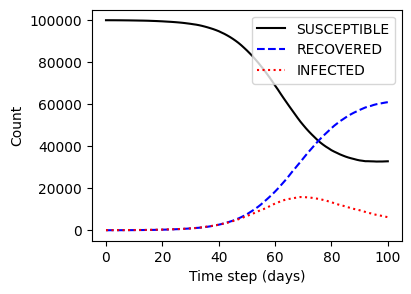

In [6]:
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
t = output['time']
colors = iter(['k', 'blue', 'red'])
lss = iter(['-', '--', ':', '-.'])
for status in set(simsurveillance.InfectionStatus).intersection(set(output.columns) - {'time'}):
    ax.plot(t, output[status], label=status.name, color=next(colors), ls=next(lss))
ax.legend(loc='upper right')
ax.set_xlabel('Time step (days)')
ax.set_ylabel('Count')

plt.show()

Next, we view the actual information about this simulated epidemic that was recorded by the observation processes. For the cases observed by symptomatic testing, we also overlay the true number of all new infected within that time step. For the results of the simulated prevalence survey, we plot the posterior median prevalence using a dot and the central 95% of the posterior using a bar.

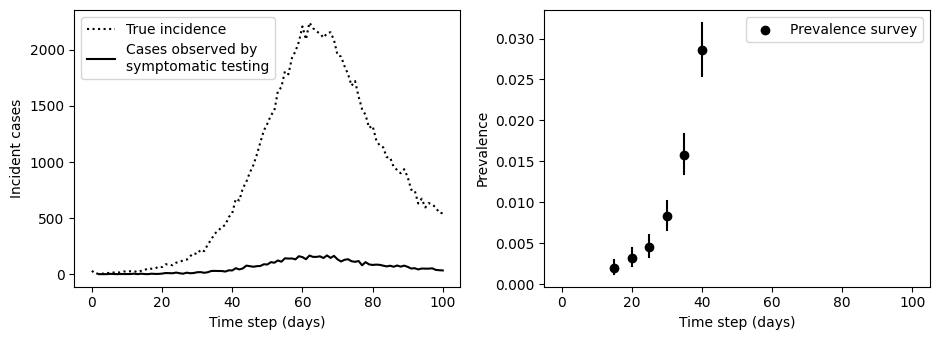

In [7]:
fig = plt.figure(figsize=(9.5, 3.5))
ax = fig.add_subplot(1, 2, 1)

ax.plot(output['time'], output['transmissions'], label='True incidence', ls=':', color='k')

sympt_times = symptomatic_testing.times
sympt_cases = symptomatic_testing.cases
ax.plot(sympt_times, sympt_cases, label='Cases observed by\nsymptomatic testing', ls='-', color='k')

ax.set_xlabel('Time step (days)')
ax.set_ylabel('Incident cases')
ax.legend(loc='upper left')

ax = fig.add_subplot(1, 2, 2, sharex=ax)

posteriors = prevalence_survey.uncertainty()

medians = [p.median() for p in posteriors]
lower_bounds = [p.interval(0.95)[0] for p in posteriors]
upper_bounds = [p.interval(0.95)[1] for p in posteriors]

ax.scatter(prevalence_survey.times, medians, label='Prevalence survey', color='k')

for t, lower, upper in zip(prevalence_survey.times, lower_bounds, upper_bounds):
    ax.plot([t, t], [lower, upper], color='k')

ax.set_xlabel('Time step (days)')
ax.set_ylabel('Prevalence')
ax.legend()

fig.set_tight_layout(True)
plt.show()

To assess the observations, we infer a forecast of the disease outbreak by fitting an SIRS differential equation model to the prevalence survey and the symptomatic testing up till day 40.

In [8]:
with open('../simsurveillance/SIRS_model.stan', 'r') as f:
    stan_code = f.read()

final_observation_time = 41
idx = symptomatic_testing.times.index(final_observation_time)

observed_cases_times = symptomatic_testing.times[:idx]
observed_cases = symptomatic_testing.cases[:idx]

data = {
    'num_cases': len(observed_cases),
    'case_times': observed_cases_times,
    'cases': observed_cases,
    'num_prevalences': len(prevalence_survey.times),
    'prev_times': prevalence_survey.times,
    'prev_as': [p.args[0] for p in posteriors],
    'prev_bs': [p.args[1] for p in posteriors],
    'N': N,
    'final_t': len(times),
    # 'transmission_rate': simulation_params['transmission_rate'],
    # 'recovery_rate': simulation_params['recovery_rate'],
    # 'waning_rate': simulation_params['waning_rate'],
    # 'num_init_infect': num_init_infect,
}

posterior = stan.build(stan_code, data=data, random_seed=12345)
init_dict = {}
fit = posterior.sample(num_chains=2, init=[init_dict]*2, num_samples=1000, num_warmup=500)
df = fit.to_frame()
arviz.summary(fit)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/vj/jcrvy37s7t9bhnsqjkpz4d2c0000gn/T/httpstan_ym2u3wsg/model_phjdypfh.stan', line 2, column 2: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.33.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/var/folders/vj/jcrvy37s7t9bhnsqjkpz4d2c0000gn/T/httpstan_ym2u3wsg/model_phjdypfh.stan', line 2, column 24: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.33.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/var/folders/vj/jcrvy37s7t9bhnsqjkpz4d2c0000gn/T/httpstan_ym2u3wsg/model_phjdypfh.stan', line 2, column 38: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.33.0. Instead

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
transmission_rate,0.237,0.013,0.212,0.260,0.000,0.000,683.0,955.0,1.0
recovery_rate,0.125,0.011,0.105,0.147,0.000,0.000,755.0,883.0,1.0
waning_rate,0.010,0.003,0.005,0.016,0.000,0.000,1205.0,930.0,1.0
case_ascertainment,0.066,0.005,0.056,0.075,0.000,0.000,742.0,991.0,1.0
sigma,3.277,0.396,2.561,3.998,0.011,0.008,1532.0,1187.0,1.0
...,...,...,...,...,...,...,...,...,...
"y_projection[99, 3]",0.835,0.043,0.751,0.909,0.001,0.001,1337.0,1035.0,1.0
"y_projection[100, 0]",0.356,0.034,0.294,0.423,0.001,0.001,1124.0,1021.0,1.0
"y_projection[100, 1]",0.060,0.014,0.034,0.084,0.000,0.000,783.0,1020.0,1.0
"y_projection[100, 2]",0.585,0.034,0.521,0.648,0.001,0.001,1290.0,1032.0,1.0


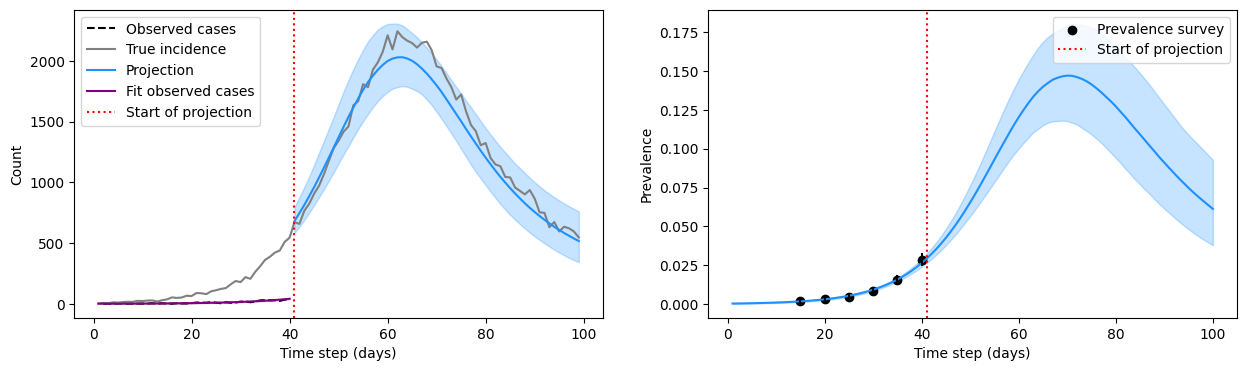

In [9]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 2, 1)

num_mcmc = 2000

fits_all_cases = []
fits_observed_cases = []

for j in range(num_mcmc):
    fit_all_cases = [df['y_projection.{}.{}'.format(i, 4)].values[j] * N for i in times[1:]]
    fit_observed_cases = [x * df['case_ascertainment'].values[j] for x in fit_all_cases]

    fit_all_cases = [0] + list(np.diff(fit_all_cases))
    fit_observed_cases = [0] + list(np.diff(fit_observed_cases))

    fits_all_cases.append(fit_all_cases)
    fits_observed_cases.append(fit_observed_cases)


ax.plot(observed_cases_times, observed_cases, label='Observed cases', color='k', ls='--')
ax.plot(output['time'][1:-1], output['transmissions'][1:-1], label='True incidence', color='gray', ls='-')

ax.plot(
    times[final_observation_time:-1],
    np.median(fits_all_cases, axis=0)[final_observation_time:],
    color='dodgerblue',
    label='Projection'
)
ax.fill_between(
    times[final_observation_time:-1],
    np.percentile(fits_all_cases, 2.5, axis=0)[final_observation_time:],
    np.percentile(fits_all_cases, 97.5, axis=0)[final_observation_time:],
    color='dodgerblue',
    alpha=0.25
)

ax.plot(
    times[1:final_observation_time],
    np.median(fits_observed_cases, axis=0)[1:final_observation_time],
    color='purple',
    label='Fit observed cases'
)
ax.fill_between(
    times[1:final_observation_time],
    np.percentile(fits_observed_cases, 2.5, axis=0)[1:final_observation_time],
    np.percentile(fits_observed_cases, 97.5, axis=0)[1:final_observation_time],
    color='purple',
    alpha=0.25
)

ax.axvline(final_observation_time, color='red', ls=':', label='Start of projection')

ax.set_xlabel('Time step (days)')
ax.set_ylabel('Count')
ax.legend()


ax = fig.add_subplot(1, 2, 2)

fits_prevalence = []

for j in range(num_mcmc):
    fits_prevalence.append([df['y_projection.{}.{}'.format(i, 2)].values[j] for i in times[1:]])

ax.plot(
    times[1:],
    np.median(fits_prevalence, axis=0),
    color='dodgerblue',
)
ax.fill_between(
    times[1:],
    np.percentile(fits_prevalence, 2.5, axis=0),
    np.percentile(fits_prevalence, 97.5, axis=0),
    color='dodgerblue',
    alpha=0.25
)

ax.scatter(prevalence_survey.times, medians, label='Prevalence survey', color='k')
for t, lower, upper in zip(prevalence_survey.times, lower_bounds, upper_bounds):
    ax.plot([t, t], [lower, upper], color='k')

ax.axvline(final_observation_time, color='red', ls=':', label='Start of projection')

ax.set_xlabel('Time step (days)')
ax.set_ylabel('Prevalence')
ax.legend()

plt.show()

In [10]:
model = simsurveillance.SIRSAgentModel(N, seed=123)
model.params.set_parameters(simulation_params)
model.initialize_infection(num_init_infect)

test = simsurveillance.DiseaseTest()
symptomatic_testing = simsurveillance.SymptomaticTesting(
    model,
    test,
    start_time=10
)
test_days = [20, 30, 40]
num_to_test = 10
prevalence_survey2 = simsurveillance.PrevalenceSurvey(
    model, 
    test,
    test_days,
    [num_to_test] * len(test_days)
)
model.add_observers(symptomatic_testing, prevalence_survey2)

output2 = model.simulate(times)
posteriors2 = prevalence_survey2.uncertainty()
medians2 = [p.median() for p in posteriors2]
lower_bounds2 = [p.interval(0.95)[0] for p in posteriors2]
upper_bounds2 = [p.interval(0.95)[1] for p in posteriors2]

In [11]:
with open('../simsurveillance/SIRS_model.stan', 'r') as f:
    stan_code = f.read()

idx = symptomatic_testing.times.index(final_observation_time)

observed_cases_times = symptomatic_testing.times[:idx]
observed_cases = symptomatic_testing.cases[:idx]

data = {
    'num_cases': len(observed_cases),
    'case_times': observed_cases_times,
    'cases': observed_cases,
    'num_prevalences': len(prevalence_survey2.times),
    'prev_times': prevalence_survey2.times,
    'prev_as': [p.args[0] for p in posteriors2],
    'prev_bs': [p.args[1] for p in posteriors2],
    'N': N,
    'final_t': len(times),
}

posterior = stan.build(stan_code, data=data, random_seed=1234)
fit2 = posterior.sample(num_chains=2, init=[init_dict]*2, num_samples=1000, num_warmup=500)
df2 = fit2.to_frame()
arviz.summary(fit2)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/vj/jcrvy37s7t9bhnsqjkpz4d2c0000gn/T/httpstan_ym2u3wsg/model_phjdypfh.stan', line 2, column 2: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.33.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/var/folders/vj/jcrvy37s7t9bhnsqjkpz4d2c0000gn/T/httpstan_ym2u3wsg/model_phjdypfh.stan', line 2, column 24: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.33.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/var/folders/vj/jcrvy37s7t9bhnsqjkpz4d2c0000gn/T/httpstan_ym2u3wsg/model_phjdypfh.stan', line 2, column 38: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.33.0. Instead

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
transmission_rate,0.221,0.014,0.193,0.247,0.001,0.001,257.0,274.0,1.00
recovery_rate,0.124,0.012,0.102,0.145,0.001,0.001,267.0,331.0,1.01
waning_rate,0.010,0.003,0.005,0.016,0.000,0.000,264.0,534.0,1.01
case_ascertainment,0.151,0.146,0.050,0.422,0.010,0.007,165.0,310.0,1.00
sigma,3.607,0.490,2.743,4.432,0.027,0.019,316.0,305.0,1.00
...,...,...,...,...,...,...,...,...,...
"y_projection[99, 3]",0.709,0.101,0.507,0.876,0.006,0.004,284.0,491.0,1.01
"y_projection[100, 0]",0.427,0.062,0.313,0.543,0.003,0.002,413.0,521.0,1.00
"y_projection[100, 1]",0.079,0.024,0.039,0.121,0.002,0.001,166.0,187.0,1.01
"y_projection[100, 2]",0.494,0.074,0.337,0.609,0.004,0.003,274.0,522.0,1.00


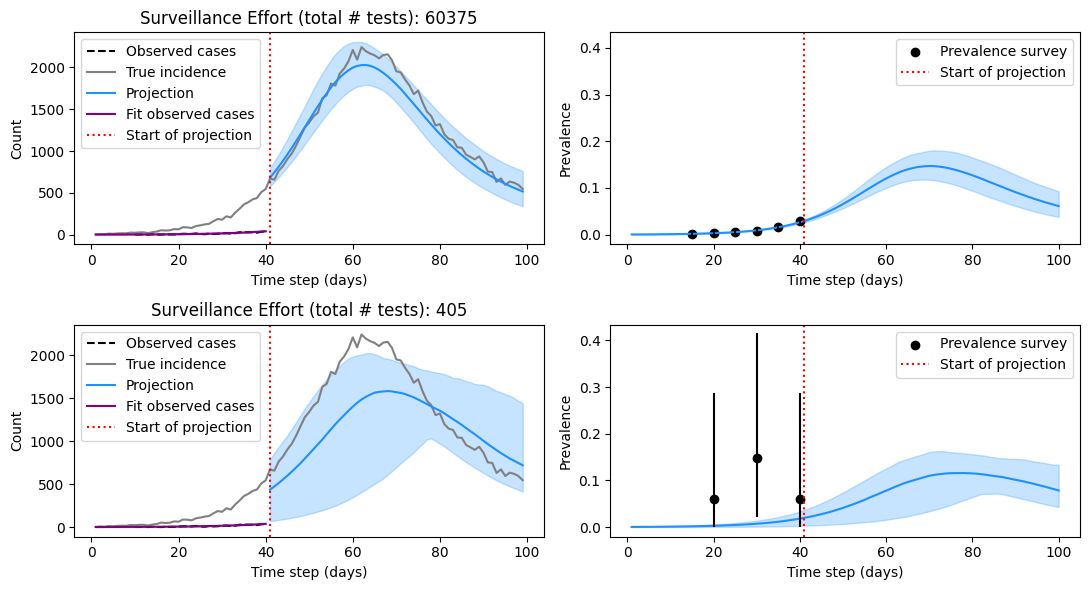

In [12]:
fig = plt.figure(figsize=(11, 6))

ax = fig.add_subplot(2, 2, 1)

ax.set_title('Surveillance Effort (total # tests): {}'.format(sum(observed_cases) + sum(prevalence_survey.num_tested)))

num_mcmc = 2000

fits_all_cases = []
fits_observed_cases = []

for j in range(num_mcmc):
    fit_all_cases = [df['y_projection.{}.{}'.format(i, 4)].values[j] * N for i in times[1:]]
    fit_observed_cases = [x * df['case_ascertainment'].values[j] for x in fit_all_cases]

    fit_all_cases = [0] + list(np.diff(fit_all_cases))
    fit_observed_cases = [0] + list(np.diff(fit_observed_cases))

    fits_all_cases.append(fit_all_cases)
    fits_observed_cases.append(fit_observed_cases)


ax.plot(observed_cases_times, observed_cases, label='Observed cases', color='k', ls='--')
ax.plot(output['time'][1:-1], output['transmissions'][1:-1], label='True incidence', color='gray', ls='-')

ax.plot(
    times[final_observation_time:-1],
    np.median(fits_all_cases, axis=0)[final_observation_time:],
    color='dodgerblue',
    label='Projection'
)
ax.fill_between(
    times[final_observation_time:-1],
    np.percentile(fits_all_cases, 2.5, axis=0)[final_observation_time:],
    np.percentile(fits_all_cases, 97.5, axis=0)[final_observation_time:],
    color='dodgerblue',
    alpha=0.25
)

ax.plot(
    times[1:final_observation_time],
    np.median(fits_observed_cases, axis=0)[1:final_observation_time],
    color='purple',
    label='Fit observed cases'
)
ax.fill_between(
    times[1:final_observation_time],
    np.percentile(fits_observed_cases, 2.5, axis=0)[1:final_observation_time],
    np.percentile(fits_observed_cases, 97.5, axis=0)[1:final_observation_time],
    color='purple',
    alpha=0.25
)

ax.axvline(final_observation_time, color='red', ls=':', label='Start of projection')

ax.set_xlabel('Time step (days)')
ax.set_ylabel('Count')
ax.legend()


ax = fig.add_subplot(2, 2, 2)

fits_prevalence = []

for j in range(num_mcmc):
    fits_prevalence.append([df['y_projection.{}.{}'.format(i, 2)].values[j] for i in times[1:]])

ax.plot(
    times[1:],
    np.median(fits_prevalence, axis=0),
    color='dodgerblue',
)
ax.fill_between(
    times[1:],
    np.percentile(fits_prevalence, 2.5, axis=0),
    np.percentile(fits_prevalence, 97.5, axis=0),
    color='dodgerblue',
    alpha=0.25
)

ax.scatter(prevalence_survey.times, medians, label='Prevalence survey', color='k')
for t, lower, upper in zip(prevalence_survey.times, lower_bounds, upper_bounds):
    ax.plot([t, t], [lower, upper], color='k')

ax.axvline(final_observation_time, color='red', ls=':', label='Start of projection')

ax.set_xlabel('Time step (days)')
ax.set_ylabel('Prevalence')
ax.legend()

ax_top = ax

#############

ax = fig.add_subplot(2, 2, 3)

ax.set_title('Surveillance Effort (total # tests): {}'.format(sum(observed_cases) + sum(prevalence_survey2.num_tested)))

fits_all_cases = []
fits_observed_cases = []

for j in range(num_mcmc):
    fit_all_cases = [df2['y_projection.{}.{}'.format(i, 4)].values[j] * N for i in times[1:]]
    fit_observed_cases = [x * df2['case_ascertainment'].values[j] for x in fit_all_cases]

    fit_all_cases = [0] + list(np.diff(fit_all_cases))
    fit_observed_cases = [0] + list(np.diff(fit_observed_cases))

    fits_all_cases.append(fit_all_cases)
    fits_observed_cases.append(fit_observed_cases)


ax.plot(observed_cases_times, observed_cases, label='Observed cases', color='k', ls='--')
ax.plot(output2['time'][1:-1], output2['transmissions'][1:-1], label='True incidence', color='gray', ls='-')

ax.plot(
    times[final_observation_time:-1],
    np.median(fits_all_cases, axis=0)[final_observation_time:],
    color='dodgerblue',
    label='Projection'
)
ax.fill_between(
    times[final_observation_time:-1],
    np.percentile(fits_all_cases, 2.5, axis=0)[final_observation_time:],
    np.percentile(fits_all_cases, 97.5, axis=0)[final_observation_time:],
    color='dodgerblue',
    alpha=0.25
)

ax.plot(
    times[1:final_observation_time],
    np.median(fits_observed_cases, axis=0)[1:final_observation_time],
    color='purple',
    label='Fit observed cases'
)
ax.fill_between(
    times[1:final_observation_time],
    np.percentile(fits_observed_cases, 2.5, axis=0)[1:final_observation_time],
    np.percentile(fits_observed_cases, 97.5, axis=0)[1:final_observation_time],
    color='purple',
    alpha=0.25
)

ax.axvline(final_observation_time, color='red', ls=':', label='Start of projection')

ax.set_xlabel('Time step (days)')
ax.set_ylabel('Count')
ax.legend()


ax = fig.add_subplot(2, 2, 4, sharey=ax_top)

fits_prevalence = []

for j in range(num_mcmc):
    fits_prevalence.append([df2['y_projection.{}.{}'.format(i, 2)].values[j] for i in times[1:]])

ax.plot(
    times[1:],
    np.median(fits_prevalence, axis=0),
    color='dodgerblue',
)
ax.fill_between(
    times[1:],
    np.percentile(fits_prevalence, 2.5, axis=0),
    np.percentile(fits_prevalence, 97.5, axis=0),
    color='dodgerblue',
    alpha=0.25
)

ax.scatter(prevalence_survey2.times, medians2, label='Prevalence survey', color='k')
for t, lower, upper in zip(prevalence_survey2.times, lower_bounds2, upper_bounds2):
    ax.plot([t, t], [lower, upper], color='k')

ax.axvline(final_observation_time, color='red', ls=':', label='Start of projection')

ax.set_xlabel('Time step (days)')
ax.set_ylabel('Prevalence')
ax.legend()

fig.set_tight_layout(True)

plt.show()